In [1]:
import glob
import json
import os
import pickle
import unicodedata

from lightgbm import LGBMClassifier
import numpy as np
import pandas as pd
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
import torch
import torchvision
from tqdm.auto import tqdm
%matplotlib inline

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [3]:
pd.options.display.max_rows = pd.options.display.max_columns = 50
pd.options.display.float_format = '{:.3f}'.format

In [4]:
OUTPUT_DIR = os.path.join('..', 'data', 'eda-003')
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [5]:
INPUT_DIR = os.path.join(os.path.expanduser('~'), 'datasets', 'nishika', 'bokete')
assert os.path.isdir(INPUT_DIR)
train = pd.read_csv(os.path.join(INPUT_DIR, 'train.csv'))
test = pd.read_csv(os.path.join(INPUT_DIR, 'test.csv'))
sample_submission = pd.read_csv(os.path.join(INPUT_DIR, 'sample_submission.csv'))

In [6]:
cv = pd.read_csv(os.path.join('..', 'fold', 'cv.csv'))
cv

,odai_photo_file_name,oof_fold
0,9fkys1gb2r.jpg,4
1,c6ag0m1lak.jpg,3
2,whtn6gb9ww.jpg,3
3,6yk5cwmrsy.jpg,0
4,0i9gsa2jsm.jpg,4
...,...,...
24957,5ctq9ohpge.jpg,3
24958,dcj9pepjwf.jpg,1
24959,ks04y4iy7i.jpg,2
24960,cgfkktchbz.jpg,4


In [7]:
%%time
weights = torchvision.models.VGG16_Weights.IMAGENET1K_V1
model = torchvision.models.vgg16(weights=weights).to(DEVICE)
model.eval()
transforms = weights.transforms()

CPU times: total: 1.62 s
Wall time: 1.76 s


In [8]:
def read_jpg(path):
    image_tensor = torchvision.io.read_image(path)
    if image_tensor.shape[0] == 1:
        # 1channel=白黒画像があるので3channelにconvertしています。
        image_tensor = image_tensor.expand(3, *image_tensor.shape[1:])
    return image_tensor

In [9]:
%%time
X = {}
with torch.inference_mode():
    for filename in tqdm(train['odai_photo_file_name'].to_numpy()):
        image = read_jpg(os.path.join(os.path.join(INPUT_DIR, 'train', filename)))
        image_transformed = transforms(image).unsqueeze(0).to(DEVICE)
        X[filename] = model(image_transformed).to('cpu').detach().numpy().copy()[0]

  0%|          | 0/24962 [00:00<?, ?it/s]

CPU times: total: 21min 28s
Wall time: 13min 29s


In [10]:
X = pd.DataFrame(X).T
X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
9fkys1gb2r.jpg,-1.123,-1.076,-1.011,-1.646,-1.795,-2.899,-1.760,4.911,4.344,4.213,-3.160,-0.722,-2.080,-1.448,-1.791,-0.515,-1.945,0.873,1.674,0.863,1.236,-0.042,1.633,1.667,3.568,...,1.229,0.785,2.342,2.548,3.400,4.669,-1.918,0.431,-1.080,-0.312,1.423,-2.999,0.773,-1.697,0.412,1.847,2.071,-0.445,-0.751,-0.948,2.110,3.969,-1.053,0.393,0.532
c6ag0m1lak.jpg,0.999,-1.010,-0.080,-1.189,1.057,-0.803,-0.172,0.171,-0.919,-1.630,-0.179,-1.615,-1.809,-0.367,-1.751,-1.035,-0.457,-1.039,-1.296,-0.347,-2.115,-0.509,-0.623,-1.022,-1.587,...,-1.213,-1.954,-0.050,-1.562,-2.680,-1.715,3.693,2.444,-2.033,0.387,-1.593,-2.533,2.234,-0.644,-1.245,-1.391,-1.558,-2.430,-0.567,-1.844,-0.428,0.336,0.044,1.824,1.356
whtn6gb9ww.jpg,1.141,-2.713,-0.210,-2.992,-0.258,-1.425,-1.711,1.472,-1.380,-2.408,-1.030,-2.098,-1.061,-1.326,-1.533,-1.297,0.206,-1.388,-1.362,-1.555,-1.091,-0.039,-1.595,-1.147,-1.933,...,-0.967,-2.792,-0.864,-1.636,-3.705,-2.959,1.431,4.029,-2.014,-0.590,-1.948,-0.974,1.515,-0.522,-2.744,-0.881,-3.007,-3.641,-1.693,-2.234,-1.380,-1.297,-1.032,2.970,0.135
6yk5cwmrsy.jpg,1.883,-0.551,-0.905,-2.497,-0.579,-2.451,-2.157,0.030,-0.711,-1.233,-0.607,5.584,0.932,0.724,2.629,-1.162,3.748,2.731,0.518,1.812,-0.064,2.433,2.307,0.642,-0.352,...,1.339,-2.144,0.596,0.556,-3.941,-4.842,5.214,1.557,0.461,5.079,1.369,4.287,4.384,3.740,1.733,-0.329,-0.630,-1.847,-2.897,-1.026,-1.124,-0.827,0.118,6.345,0.285
0i9gsa2jsm.jpg,0.328,-3.463,-1.070,-1.734,-2.163,-1.057,-2.684,0.692,-2.473,-4.305,-2.887,-3.483,-3.315,-4.801,-1.256,-4.080,-5.337,-1.034,-2.597,-3.899,-5.946,-2.941,-2.763,-1.569,-2.379,...,-0.723,-2.104,-1.487,-3.315,-2.371,-1.808,0.889,1.581,-1.452,-1.456,-2.876,-4.904,0.124,-3.582,-2.674,-2.523,-3.770,-2.769,-1.764,-3.724,-3.309,1.740,-1.235,-0.441,1.842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5ctq9ohpge.jpg,0.567,0.556,-2.155,-3.251,-2.254,-0.815,-3.491,2.002,-0.484,-5.638,-0.566,-2.516,-1.248,-2.306,-1.092,-1.585,-2.427,-2.564,-3.608,-1.296,-1.771,-0.837,-2.610,-2.098,-2.880,...,-2.746,-4.136,-1.690,-2.173,-4.262,-0.159,4.044,3.639,-4.504,-0.939,-2.317,-1.313,0.878,-1.265,-1.441,-1.514,-3.481,-2.195,-0.260,-1.379,-0.822,0.104,-1.451,0.699,2.413
dcj9pepjwf.jpg,-2.187,-1.624,1.951,0.069,2.951,-0.807,1.576,2.585,-0.826,0.751,-4.110,-5.091,-3.888,-4.161,-3.550,-3.929,-4.035,-3.435,-2.318,-3.279,-4.153,-3.522,-3.307,-1.304,-3.720,...,0.557,0.264,4.363,2.996,-0.077,2.352,4.252,-1.434,0.646,-1.775,-5.560,-5.277,0.350,-2.406,-3.358,-1.697,-2.878,-3.394,-3.457,-4.012,-2.932,-2.235,-2.625,1.212,2.677
ks04y4iy7i.jpg,-1.431,-1.864,-1.918,-3.008,-2.376,-1.713,-3.224,-2.799,-2.926,-0.625,-2.216,-1.941,-2.173,-2.063,-2.768,-0.377,-2.645,-1.773,-0.628,-1.506,-2.846,-1.101,-0.642,-0.051,-1.231,...,3.432,3.158,3.477,3.463,1.257,1.174,-0.696,3.182,-2.381,0.930,-0.949,-2.587,0.014,-1.751,-4.004,-2.255,-3.941,-4.359,-4.072,-3.917,-2.019,-2.455,-3.256,-0.014,-0.675
cgfkktchbz.jpg,0.013,-0.406,-0.807,-2.387,-2.297,-2.883,-1.682,-0.176,-0.419,-1.810,0.561,-0.694,-0.194,-0.010,-0.549,-1.375,0.347,-0.673,-2.287,-0.416,-2.059,-1.564,-1.950,-1.184,-1.512,...,-1.534,-2.286,-0.562,-1.605,-2.876,-1.135,0.572,5.862,-2.436,1.667,-0.538,-2.251,3.672,-0.917,-0.464,-2.537,-1.356,-1.507,-0.838,-0.885,-1.694,-0.387,-0.851,4.984,2.505


In [11]:
%%time
X_test = {}
with torch.inference_mode():
    for filename in tqdm(test['odai_photo_file_name'].to_numpy()):
        image = read_jpg(os.path.join(os.path.join(INPUT_DIR, 'test', filename)))
        image_transformed = transforms(image).unsqueeze(0).to(DEVICE)
        X_test[filename] = model(image_transformed).to('cpu').detach().numpy().copy()[0]

  0%|          | 0/6000 [00:00<?, ?it/s]

CPU times: total: 5min 4s
Wall time: 3min 15s


In [12]:
X_test = pd.DataFrame(X_test).T
X_test

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
nc1kez326b.jpg,3.170,1.109,0.184,-2.539,-4.445,-0.069,-1.329,1.757,-0.369,-3.600,-2.297,1.979,-0.278,-4.172,-2.681,-3.270,-3.085,-1.305,-2.791,-3.284,-4.809,-2.237,-3.437,-0.825,-3.033,...,-1.573,-4.388,0.450,-0.581,-4.533,-2.164,4.929,-0.316,3.392,-2.483,-2.652,-3.170,2.953,0.137,-1.143,-0.865,-4.008,1.403,-4.805,-0.884,-1.898,-2.455,-2.040,1.563,0.325
49xt2fmjw0.jpg,2.802,0.328,3.484,3.820,6.019,3.383,6.508,0.328,-3.183,-0.653,-3.140,-2.626,-3.527,-4.015,-2.936,-2.205,-1.658,-2.197,-2.988,-3.854,-2.930,-0.096,-2.108,-2.889,-6.305,...,6.903,4.993,10.708,12.030,2.149,1.677,0.770,-1.491,6.189,0.921,-5.881,-2.996,0.873,-1.289,-2.579,-3.510,-0.844,-3.332,1.510,-1.197,-1.265,-1.418,-3.306,0.870,-0.278
9dtscjmyfh.jpg,2.036,0.073,-2.030,-1.231,-1.869,2.728,-1.854,-2.051,-0.812,-5.953,-1.742,-1.549,-2.192,-3.453,-3.304,-2.524,-4.089,-3.549,-5.524,-2.017,-4.831,-3.356,-4.268,-2.880,-3.201,...,-1.036,-1.961,-1.199,-1.591,-3.038,-1.753,-2.052,5.815,-0.939,-2.403,2.071,1.631,2.859,3.043,1.922,5.065,2.342,2.734,4.470,5.615,7.145,8.802,3.838,3.203,2.592
osa3n56tiv.jpg,-2.149,-0.022,-1.561,-3.415,-0.304,-1.860,-1.516,-2.394,-2.240,-3.913,-1.554,-2.032,-1.323,-0.448,-1.361,-3.298,-1.054,-2.770,-1.878,-1.408,-2.422,-4.353,-3.325,-4.612,-4.572,...,-0.958,-1.281,2.678,1.763,-3.280,-5.098,-0.253,1.707,-4.193,1.170,-2.947,-4.912,3.226,-3.005,-1.957,-1.508,-2.990,-2.664,-1.913,-4.706,-2.739,-1.597,-2.759,3.311,6.764
yb1yqs4pvb.jpg,-2.497,-3.376,-0.410,-1.882,-0.476,-0.520,-0.906,0.662,-0.086,-3.659,-1.256,-3.843,-1.221,-2.800,-1.362,-1.815,-2.212,-2.156,-1.693,-2.289,-2.009,-3.373,-3.835,-1.704,-2.489,...,-1.372,-2.848,-0.612,-1.944,-2.824,-2.779,-0.124,2.692,-4.065,-3.729,-4.046,-4.412,0.347,-3.340,-2.509,-3.068,-4.568,-2.639,-2.073,-3.639,-1.837,0.371,-2.166,0.507,0.909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0bgwr5po4l.jpg,-2.886,-1.186,-0.512,-1.788,-0.643,-0.593,-3.270,-0.766,-1.983,-2.209,-2.916,-1.704,-2.324,-3.468,-1.188,-2.510,-2.125,-2.064,-0.911,-3.690,-3.896,-3.586,-2.335,-2.326,-3.543,...,0.023,-1.906,-1.187,0.161,-2.292,0.899,0.941,-0.436,-0.514,-0.454,0.864,-1.653,0.838,1.080,0.333,0.769,0.463,-1.459,-0.500,-1.149,0.246,-0.845,-2.901,0.206,1.165
3wgkjwrq11.jpg,0.253,-2.051,-0.006,-2.638,-0.527,-0.951,-2.103,2.045,-1.120,-2.979,-2.669,-4.630,-3.568,-3.900,-2.618,-2.310,-2.111,-2.518,-2.802,-3.050,-3.010,-2.195,-3.735,-1.707,-1.595,...,-3.605,-4.368,-2.746,-4.603,-4.372,-2.047,2.105,2.018,-4.215,-3.133,-3.096,-2.776,1.479,-3.215,-4.489,-2.501,-4.393,-3.667,-1.960,-3.248,-3.440,-0.695,-1.356,2.251,0.076
rny98dohwa.jpg,0.942,-3.313,-2.785,-2.795,-1.730,-3.122,-3.871,0.000,-1.299,-1.686,-4.004,-2.215,-2.337,-3.016,-2.206,-2.134,-2.532,-3.069,-0.010,-2.312,-2.588,-2.114,-1.324,-1.117,-0.088,...,1.909,-2.039,2.641,1.088,0.031,-2.018,4.230,2.937,1.602,0.617,-0.543,-2.727,-1.486,-1.888,-1.774,-0.894,-4.393,-3.206,-5.226,-4.036,-1.727,-2.777,-4.030,-1.012,0.816
rlrze2yhes.jpg,1.535,-1.594,1.173,1.002,3.083,-0.285,0.253,0.193,-1.279,-1.321,-1.660,-1.874,-0.368,-0.145,-0.369,-1.485,-0.356,0.365,-1.360,-1.097,-0.507,-1.288,-2.114,-0.568,-1.242,...,-0.073,-1.982,0.487,-0.803,-3.521,-2.624,8.893,-0.733,-1.204,-0.790,-3.054,-1.769,0.599,-0.734,-1.940,-1.608,-3.363,-2.252,-1.819,-2.569,-1.298,-1.642,-0.433,-0.522,1.107


In [13]:
train = train.set_index('odai_photo_file_name').sort_index()

In [14]:
train = train.loc[X.index]
assert (train.index == X.index).all()

In [15]:
%%time
prediction_train = []
prediction_valid = []
metrics = {'train_loss': [], 'valid_loss': []}
models = []

for oof_fold, fold_df in tqdm(cv.groupby('oof_fold')):

    mask = train.index.isin(fold_df['odai_photo_file_name'])
    X_train = X.loc[mask, :].copy()
    y_train = train.loc[mask, 'is_laugh'].copy()
    X_valid = X.loc[~mask, :].copy()
    y_valid = train.loc[~mask, 'is_laugh'].copy()

    model = LGBMClassifier(random_state=293847, n_jobs=-1, importance_type='gain', objective='binary').fit(X_train, y_train)
    models.append(model)

    pred_train = model.predict_proba(X_train)[:, -1]
    pred_valid = model.predict_proba(X_valid)[:, -1]
    loss_train = log_loss(y_train, pred_train)
    loss_valid = log_loss(y_valid, pred_valid)

    metrics['train_loss'].append(loss_train)
    metrics['valid_loss'].append(loss_valid)

    prediction_train_ = pd.DataFrame({
        'id': train.loc[mask, 'id'].to_numpy(),
        'probability': pred_train
    })
    prediction_train.append(prediction_train_)

    prediction_valid_ = pd.DataFrame({
        'id': train.loc[~mask, 'id'].to_numpy(),
        'probability': pred_valid
    })
    prediction_valid.append(prediction_valid_)

    print(f'Fold {oof_fold}: Training loss={loss_train:.5f}, Validation loss={loss_valid:.5f}')

prediction_train = pd.concat(prediction_train)
prediction_valid = pd.concat(prediction_valid)
np.mean(metrics['train_loss']), np.mean(metrics['valid_loss'])

  0%|          | 0/5 [00:00<?, ?it/s]

Fold 0: Training loss=0.25226, Validation loss=0.72915
Fold 1: Training loss=0.25004, Validation loss=0.73572
Fold 2: Training loss=0.24653, Validation loss=0.73737
Fold 3: Training loss=0.25092, Validation loss=0.73356
Fold 4: Training loss=0.24843, Validation loss=0.73553
CPU times: total: 3min 18s
Wall time: 43.2 s


(0.24963608081950808, 0.7342651314516561)

In [16]:
with open(os.path.join(OUTPUT_DIR, 'result.json'), 'w') as f:
    json.dump(metrics, f)

In [17]:
with open(os.path.join(OUTPUT_DIR, 'models'), 'wb') as f:
    pickle.dump(models, f)

In [18]:
prediction_train.to_csv(os.path.join(OUTPUT_DIR, 'prediction_train.csv'), index=False)
prediction_valid.to_csv(os.path.join(OUTPUT_DIR, 'prediction_valid.csv'), index=False)

In [19]:
prediction_test = []
for model in models:
    pred_test = model.predict_proba(X_test)[:, -1]
    prediction_test_ = pd.DataFrame({
        'id': test['id'].to_numpy(),
        'probability': pred_test
    })
    prediction_test.append(prediction_test_)

prediction = pd.concat(prediction_test).groupby('id')['probability'].mean()
prediction

id
00256fqr5   0.511
00dg8czme   0.412
00kwnamds   0.394
00wegkbsp   0.404
02bo41c14   0.496
             ... 
zzbeh6ptp   0.464
zzbme8old   0.509
zzksgrtmg   0.351
zzv1jjbke   0.590
zzweow5o7   0.528
Name: probability, Length: 6000, dtype: float64

In [20]:
sample_submission['is_laugh'] = prediction.loc[sample_submission['id']].to_numpy()
sample_submission

,id,is_laugh
0,rfdjcfsqq,0.482
1,tsgqmfpef,0.441
2,owjcthkz2,0.472
3,rvgaocjyy,0.632
4,uxtwu5i69,0.526
...,...,...
5995,vx1lpzark,0.382
5996,y9sugbhm8,0.489
5997,dsd1yixzk,0.437
5998,vmyopn0mu,0.582


count   6000.000
mean       0.498
std        0.080
min        0.207
25%        0.445
50%        0.499
75%        0.554
max        0.779
Name: is_laugh, dtype: float64

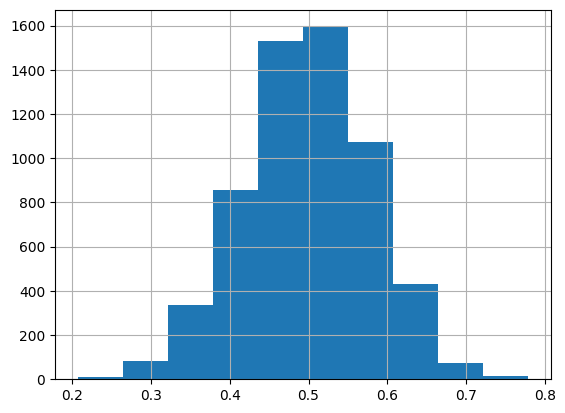

In [21]:
sample_submission['is_laugh'].hist()
sample_submission['is_laugh'].describe()

In [22]:
sample_submission.to_csv(os.path.join(OUTPUT_DIR, f'submission_{os.path.split(OUTPUT_DIR)[-1]}.csv'), index=False)